In [63]:
from category_encoders import OrdinalEncoder
from numpy.random import permutation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
DATA_PATH = '../data/'

# Merge train_features.csv & train_labels.csv
df = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv', na_values=[0, -2.000000e-08]), 
              pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('id')

In [3]:
def wrangle(X):
    # Make a copy
    X = X.copy()

    # Drop high-cardinality cols
    high_card_cols= [col for col in X.select_dtypes('object').columns
                      if X[col].nunique() > 100]

    X.drop(columns=high_card_cols, inplace=True)

    # Drop repeated columns
    cols = ['extraction_type_group', 'quantity']
    X.drop(columns=cols, inplace=True)

    return X

In [5]:
df = wrangle(df)

In [6]:
df.head()

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,...,payment_type,water_quality,quality_group,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
69572.0,6000.0,1390.0,34.938093,-9.856322,NaN,Lake Nyasa,Iringa,11,5.0,109.0,...,annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776.0,NaN,1399.0,34.698766,-2.147466,NaN,Lake Victoria,Mara,20,2.0,280.0,...,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310.0,25.0,686.0,37.460664,-3.821329,NaN,Pangani,Manyara,21,4.0,250.0,...,per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743.0,NaN,263.0,38.486161,-11.155298,NaN,Ruvuma / Southern Coast,Mtwara,90,63.0,58.0,...,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728.0,NaN,NaN,31.130847,-1.825359,NaN,Lake Victoria,Kagera,18,1.0,NaN,...,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [33]:
df['quantity_group'].nunique()

5

In [7]:
# Split our feature matrix and target vector
y = df['status_group']
X = df.drop('status_group', axis=1)

In [9]:
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Establish baseline
print('Baseline Accuracy: {:.4f}'.format(y_train.value_counts(normalize=True).max()))

Baseline Accuracy: 0.5426


In [15]:
# Build model
model_skgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    GradientBoostingClassifier(random_state=42)
)

model_skgb.fit(X_train, y_train);

In [18]:
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(random_state=42, n_jobs=-1)
)

model_xgb.fit(X_train, y_train);

In [20]:
print('Sklearn Gradient Boost Training Accuracy: {:.4f}'.format(model_skgb.score(X_train, y_train)))
print('Sklearn Gradient Boost Validation Accuracy: {:.4f}'.format(model_skgb.score(X_val, y_val)))

Sklearn Gradient Boost Training Accuracy: 0.7506
Sklearn Gradient Boost Validation Accuracy: 0.7523


In [21]:
print('XGBoost Training Accuracy: {:.4f}'.format(model_xgb.score(X_train, y_train)))
print('XGBoost Validation Accuracy: {:.4f}'.format(model_xgb.score(X_val, y_val)))

XGBoost Training Accuracy: 0.8409
XGBoost Validation Accuracy: 0.7988


In [29]:
importances = model_skgb.named_steps['gradientboostingclassifier'].feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp

recorded_by              0.000000
num_private              0.000279
water_quality            0.000956
quality_group            0.001637
management_group         0.002180
source_class             0.002506
permit                   0.002840
source_type              0.004887
public_meeting           0.005185
waterpoint_type_group    0.007307
basin                    0.007706
source                   0.008137
management               0.012485
region_code              0.012699
scheme_management        0.013014
population               0.013264
district_code            0.013650
region                   0.015240
gps_height               0.015816
payment                  0.020503
payment_type             0.025094
latitude                 0.026890
amount_tsh               0.037145
extraction_type          0.038376
extraction_type_class    0.040433
longitude                0.044551
construction_year        0.074323
waterpoint_type          0.164275
quantity_group           0.388623
dtype: float64

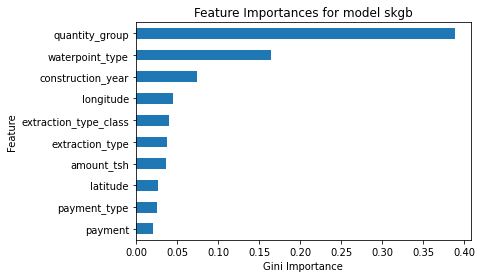

In [32]:
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for model skgb');

# When working with tree base models and feature importances, rather than regression models and their coefficients, 
# using feature importance (below) is one option, but we know it is misleading with high cardinality variables.

In [36]:
# Drop-column Importance
# Good, but computationally expensive because you have to train a model for each feature
#
# STEP 1: Train a model with the feature whose importance we want to evaluate

feature = 'quantity_group' # I can see from the graphic above that 'quantity_group' is important.  Is there another way to evaluate it's importance?

model_w_feat = model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=100,
                  random_state=42,
                  n_jobs=-1)
)

model_w_feat.fit(X_train, y_train)

print(f'Validation Accuracy with "{feature}" included:', model_w_feat.score(X_val, y_val))

Validation Accuracy with "quantity_group" included: 0.7988215488215489


In [39]:
model_wo_feat = model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=100,
                  random_state=42,
                  n_jobs=-1)
)

model_wo_feat.fit(X_train.drop(columns=feature), y_train)

print(f'Validation Accuracy without {feature}, included:', 
      model_wo_feat.score(X_val.drop(columns=feature), y_val))

# The model is about 3-4% less accurate without 'quantity_group' included
# We can it accounts for about 3-4% of the model's performance, or it's accuracy     

Validation Accuracy without quantity_group, included: 0.7643939393939394


In [43]:
X_train.shape

# We have 29 features.  If we were going to use the drop-column importance method,
# we would have to build 30 models.  One for each drop, and one which includes them all.
# ...takes for ever, and is computationally expensive.

(47519, 29)

In [44]:
# Permutation Importance
# 'By Hand'
# Feature: 'quantity_group'

# STEP 1: Train model on whole dataset (The way to go)
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=100,
                  random_state=42,
                  n_jobs=-1)
)

model_xgb.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'recorded_by', 'scheme_management',
                                      'permit', 'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity_group',
                                      'source', 'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoint_ty...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,


In [45]:
# STEP 2: Evaluate using the validation set
print('Validation Accuracy', model_xgb.score(X_val, y_val))

Validation Accuracy 0.7988215488215489


In [47]:
# STEP 3: In our VALIDATION set, permute (rearrang/shuffle-up-the-data) the feature we want to evaluate
X_val_perm = X_val.copy()

In [48]:
X_val_perm[feature].head()

id
37098.0             dry
14530.0    insufficient
71755.0          enough
55610.0          enough
19821.0          enough
Name: quantity_group, dtype: object

In [59]:
# Shuffles the data in the column and creates noise-static/takes away it's predictive power
permutation(X_val_perm[feature])[:5]

array(['enough', 'dry', 'enough', 'seasonal', 'insufficient'],
      dtype=object)

In [60]:
X_val_perm = X_val.copy()
X_val_perm[feature] = permutation(X_val_perm[feature])

In [61]:
# STEP 4: Calculate the performance metric with the permuted data
print(f'Validation Accuracy with "{feature}" permuted:', model_xgb.score(X_val_perm, y_val))

Validation Accuracy with "quantity_group" permuted: 0.6932659932659933


In [64]:
# Create above using sklearn ----- from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(
    model_xgb,
    X_val, # Always use your VALIDATION set
    y_val,
    n_jobs=100,
    random_state=42
)

In [66]:
type(perm_imp)
# A bunch kind of works like a dictionary

sklearn.utils.Bunch

In [67]:
perm_imp.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [69]:
# Put results into a DataFrame
data = {'importances_mean': perm_imp['importances_mean'],
        'importances_std': perm_imp['importances_std']}

df = pd.DataFrame(data, index=X_val.columns)
df.sort_values(by='importances_mean', inplace=True)

In [70]:
df

,importances_mean,importances_std
management_group,-0.000202,0.000067
payment_type,0.000000,0.000000
recorded_by,0.000000,0.000000
quality_group,0.000017,0.000063
num_private,0.000488,0.000378
public_meeting,0.000825,0.000557
source_type,0.000909,0.000367
waterpoint_type_group,0.001818,0.000165
source_class,0.002054,0.000375
water_quality,0.004091,0.000769


Text(0.5, 1.0, 'Permutation importance for model_xgb')

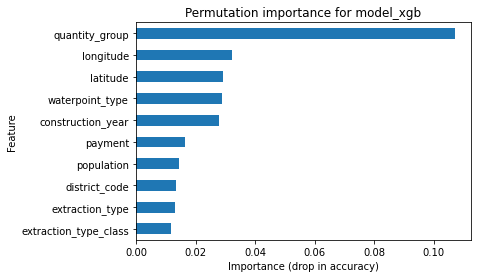

In [71]:
df['importances_mean'].tail(10).plot(kind='barh')
plt.xlabel('Importance (drop in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation importance for model_xgb')